In [32]:
import numpy as np
import numpy.linalg as la
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys
import math
import inspect
import scipy as sp
from scipy import optimize
import scipy.stats as scstats
from collections import defaultdict
# plt.rcParams["figure.figsize"] = list(map(lambda x: x * 2, plt.rcParams["figure.figsize"]))

In [33]:
def InitializeDataset(name):
    dataset = pd.read_csv(name, sep=';')
    return dataset.values

Dataset = InitializeDataset('non-parametric.csv')
points = Dataset[:,1:]
N = points.shape[0]

In [34]:
def draw(points, *results):
    h = .1
    x_min = min(points[:, 0].min(), min(p[:, 0].min() for p in results)) - 0.2
    x_max = max(points[:, 0].max(), max(p[:, 0].max() for p in results)) + 0.2
    y_min = min(points[:, 1].min(), min(p[:, 1].min() for p in results)) - 0.2
    y_max = max(points[:, 1].max(), max(p[:, 1].max() for p in results)) + 0.2

    cmap_light = ListedColormap(['#286dff', '#ffff00'])
    cmap_bold = ListedColormap(['#000000', '#ffffff'])
    plt.figure()
    plt.scatter(points[:, 0], points[:, 1], c=np.zeros(points.shape[0]), cmap=cmap_bold, linewidths=0, s=30)

    colors = ['r-', 'g-', 'b-', 'y-', 'm-', 'c-']
    for i, p in enumerate(results):
         plt.plot(p[:, 0], p[:, 1], colors[i])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()


In [35]:
def kernel_smoothing(points, kernel, width):
    def calc_y(x):
        coefs = [kernel((x - sp[0]) / width) / width for sp in points]
        return sum(c * sp[1] for (c, sp) in zip(coefs, points)) / max(sum(coefs), 0.01)
    return calc_y

In [36]:
def solve_system(a, b):
    ac = [x[:] for x in a]
    bc = b[:]
    n = len(a)
    for i in range(n - 1):
        coef = a[i + 1][i] / a[i][i]
        for j in range(i, min(n, i + 3)):
            a[i + 1][j] -= coef * a[i][j]
        b[i + 1] -= coef * b[i]
    for i in range(n - 1, 0, -1):
        coef = a[i - 1][i] / a[i][i]
        for j in range(i, max(0, i - 3), -1):
            a[i - 1][j] -= coef * a[i][j]
        b[i - 1] -= coef * b[i]
    for i in range(n):
        coef = a[i][i]
        b[i] /= coef
        a[i][i] /= coef
    return b

def spline_solve(points, kernel, lam, count=10):
    points = points.tolist()
    values = defaultdict(lambda:[])
    for p in points:
        values[p[0]].append(p[1])
    points = [[k, sum(values[k]) / len(values[k])] for k in values.keys()]
    points.sort(key=lambda a: a[0])
    points = np.array(points)
    n = points.shape[0]
    x = [p[0] for p in points]
    f = [p[1] for p in points]
    h = [max(x[i] - x[i - 1], 0.000005) if i > 0 else None for i in range(n)]

    system = [[0] * n for _ in range(n)]
    for i in range(1, n - 1):
        system[i][i - 1] += h[i]
        system[i][i] += 2 * h[i]
        system[i][i] += 2 * h[i + 1]
        system[i][i + 1] += h[i + 1]
    system = system[1:-1]
    for i in range(len(system)):
        system[i] = system[i][1:-1]
    
    need = [0] * n
    for i in range(1, n - 1):
        need[i] += (f[i + 1] - f[i]) / h[i + 1]
        need[i] -= (f[i] - f[i - 1]) / h[i]
        need[i] *= 6
    need = need[1:-1]
    
    c = [0]
    c.extend(solve_system(system, need))
    c.append(0)
    d = [c[i] - c[i - 1] if i > 0 else None for i in range(n)]
    b = [(f[i] - f[i - 1]) / h[i] + h[i] * (2 * c[i] + c[i - 1]) / 6 if i > 0 else None for i in range(n)]

    def calc_y(cx):
        if cx <= x[1]: return f[1]
        if cx >= x[-2]: return f[-2]
        i = 1
        while cx >= x[i]: i += 1
        dx = cx - x[i]
        return f[i] + b[i] * dx + c[i] / 2 * dx ** 2 + d[i] / 6 * dx ** 3
    def calc_y1(cx):
        if cx <= x[1]: return f[1]
        if cx >= x[-2]: return f[-2]
        bi = 1
        for i in range(1, len(x) - 1):
            if abs(cx - x[bi]) > abs(cx - x[i]):
                bi = i
        dx = cx - x[bi]
        return f[bi] + b[bi] * dx + c[bi] / 2 * dx ** 2 + d[bi] / 6 * dx ** 3

    return calc_y1

# spline_solve(points, None, None)

In [37]:
def spline2(points, kernel, lam):
    points = points.tolist()
    m = 10
    def getYspline(x):
        xx = points[0][0]
        yy = points[0][1]
        for i in range(1, len(points) - 2):
            xA, xB, xC, xD = points[i - 1][0], points[i][0], points[i + 1][0], points[i + 2][0]
            yA, yB, yC, yD = points[i - 1][1], points[i][1], points[i + 1][1], points[i + 2][1]
            if not (x >= xA and x <= xD):
                continue
            a3 = (-xA + 3 * (xB - xC) + xD) / 6.0
            a2 = (xA - 2 * xB + xC) / 2.0
            a1 = (xC - xA) / 2.0
            a0 = (xA + 4 * xB + xC) / 6.0
            b3 = (-yA + 3 * (yB - yC) + yD) / 6.0
            b2 = (yA - 2 * yB + yC) / 2.0
            b1 = (yC - yA) / 2.0
            b0 = (yA + 4 * yB + yC) / 6.0
            for j in range(m):
                t = (j + 1) / m
                curX = ((a3 * t + a2) * t + a1) * t + a0
                curY = ((b3 * t + b2) * t + b1) * t + b0
                if (abs(curX - x) < abs(xx - x)):
                    xx = curX
                    yy = curY
        return yy
    return spline

In [38]:
def mean_square_error(a, b):
    cnt = 0
    res = 0
    for (x, y) in zip(a, b):
        cnt += 1
        res += (x - y) ** 2
    return np.sqrt(res / cnt)

In [39]:
kernels = []
kernels.append(lambda x: 0.9375 * (1 - x ** 2) ** 2 if abs(x) <= 1 else 0)
kernels.append(lambda x: 0.75 * (1 - x ** 2) if abs(x) <= 1 else 0)
kernels.append(lambda x: np.exp(-x ** 2 / 2) / np.sqrt(2 * np.pi))
kernel_names = ['Quadratic', 'Epanechnikov', 'Gauss']


In [40]:
def Partition(dataset, blockSize):
    dataset = np.copy(dataset)
    np.random.shuffle(dataset)
    ret = []
    cnt = dataset.shape[0] // blockSize
    last = 0
    for i in range(cnt):
        c = (dataset.shape[0] + i) // cnt
        ret.append(dataset[last : last + c])
        last += c
    ret = np.array(ret)
    return ret
    
def СrossValidation(trainObjects, T, blockSize):
    trains = []
    for _ in range(0, T):
        partitions = Partition(trainObjects, blockSize)
        for i in range(0, len(partitions)):
            training_set = []
            for j in range(len(partitions)):
                if i != j:
                    training_set.extend(partitions[j])
            training_set = np.array(training_set)
            trains.append((training_set, partitions[i]))
    return trains

folds = СrossValidation(points, 1, int(points.shape[0] / 5))

In [41]:
def calc_width(points, kernel, method):
    def res_for(h):
        cur_res = 0
        global folds
        for train, check in folds:
            func = method(train, kernel, h)
            cur_res += mean_square_error([func(pt[0]) for pt in check], [pt[1] for pt in check])
        return (cur_res, h)

    best_h = res_for(0.1)
    for h in np.arange(0.1, 5, 0.3):
        best_h = min(best_h, res_for(h))
    
    return best_h[1]

In [42]:
funcs = []
names = []
for K, name in zip(kernels, kernel_names):
    width = calc_width(points, K, kernel_smoothing)
    print("width is %f" % width)
    cur = kernel_smoothing(points, K, width)
    funcs.append(cur)
    names.append(name)
funcs.append(spline_solve(points, None, None))
names.append('Spline')

width is 2.800000
width is 1.600000
width is 1.000000


In [43]:
for func, name in zip(funcs, names):
    y = points[:,1]
    cy = map(func, points[:,0])
    print('%15s error: %f' % (name, mean_square_error(y, cy)))

      Quadratic error: 27.253765
   Epanechnikov error: 25.812538
          Gauss error: 26.608749
         Spline error: 15.415530


In [44]:
xmin = points[:, 0].min()
xmax = points[:, 0].max()

new_points = [np.array([[x, func(x)] for x in np.arange(xmin, xmax, 0.1)]) for func in funcs]

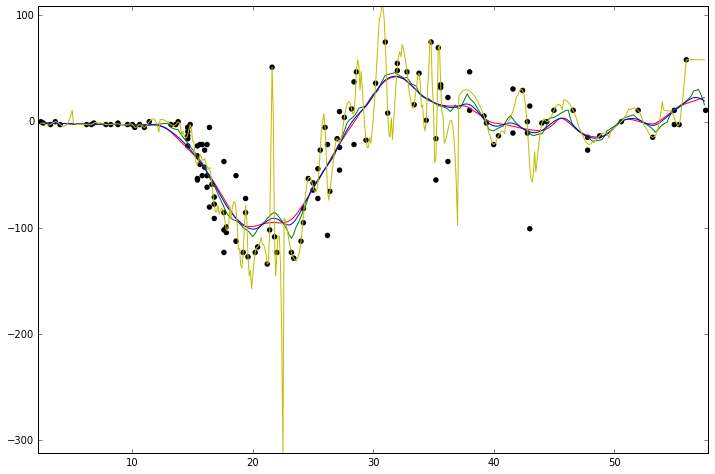

In [45]:
draw(points, *new_points)